In [1]:
!pip install lightautoml

  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.4/416.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.7/215.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 22.4 MB/s eta 0

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [3]:
TARGET_NAME = 'FloodProbability'
TEST_SIZE = 0.1
N_THREADS = 4
TIMEOUT = 3600 * 11
N_FOLDS = 5
SEED = 27

In [4]:
np.random.seed(SEED)
torch.set_num_threads(N_THREADS)

In [5]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col='id')

# Preprocessing
- Using sum feature suggested by @ambrosm [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499274)
- Sorting features as suggested by @siukeitin [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499579)
- Adding a few other statistical features which have been suggested on the forums by various people

In [6]:
def add_stat_features(dataframe, cols):
    dataframe['_sum'] = dataframe[cols].sum(1)
    dataframe['_var'] = dataframe[cols].var(1)
    dataframe['_prod'] = dataframe[cols].prod(1)
    dataframe['_mean'] = dataframe[cols].mean(1)
    dataframe['_skew'] = dataframe[cols].skew(1)
    dataframe['_median'] = dataframe[cols].median(1)

    sorted_features = [f"sort_{i}" for i in np.arange(len(cols))]
    dataframe[sorted_features] = np.sort(dataframe[cols], axis=1)
    
    return dataframe

In [7]:
feature_cols = list(test.columns)

train = add_stat_features(train, feature_cols)
train = train.drop(feature_cols, axis=1)

test = add_stat_features(test, feature_cols)
test = test.drop(feature_cols, axis=1)

In [8]:
_train, _val = train_test_split(
    train,
    test_size=TEST_SIZE,
    random_state=SEED
)

# Training

In [9]:
task = Task(
    name='reg',
    loss='mse',
    metric='r2',
    greater_is_better=True
)

In [10]:
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={
        'n_jobs': N_THREADS,
        'cv':  N_FOLDS,
        'random_state': SEED
    }
)

oof_preds = automl.fit_predict(
    _train,
    roles={'target': TARGET_NAME},
    verbose=1
)

[19:47:07] Stdout logging level is INFO.
[19:47:07] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[19:47:07] Task: reg

[19:47:07] Start automl preset with listed constraints:
[19:47:07] - time: 39600.00 seconds
[19:47:07] - CPU: 4 cores
[19:47:07] - memory: 16 GB

[19:47:07] Train data shape: (1006161, 27)



/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[19:47:17] Layer 1 train process start. Time left 39589.54 secs
[19:47:19] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:47:25] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8452720219506675
[19:47:25] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:47:25] Time left 39582.09 secs

[19:48:04] Selector_LightGBM fitting and predicting completed
[19:48:04] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:51:29] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8690700438664142
[19:51:29] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:51:29] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[19:56:29] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[19:56:29] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[19:58:39] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8691306151077879
[19:58:39] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and

In [11]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.38422 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.61578 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


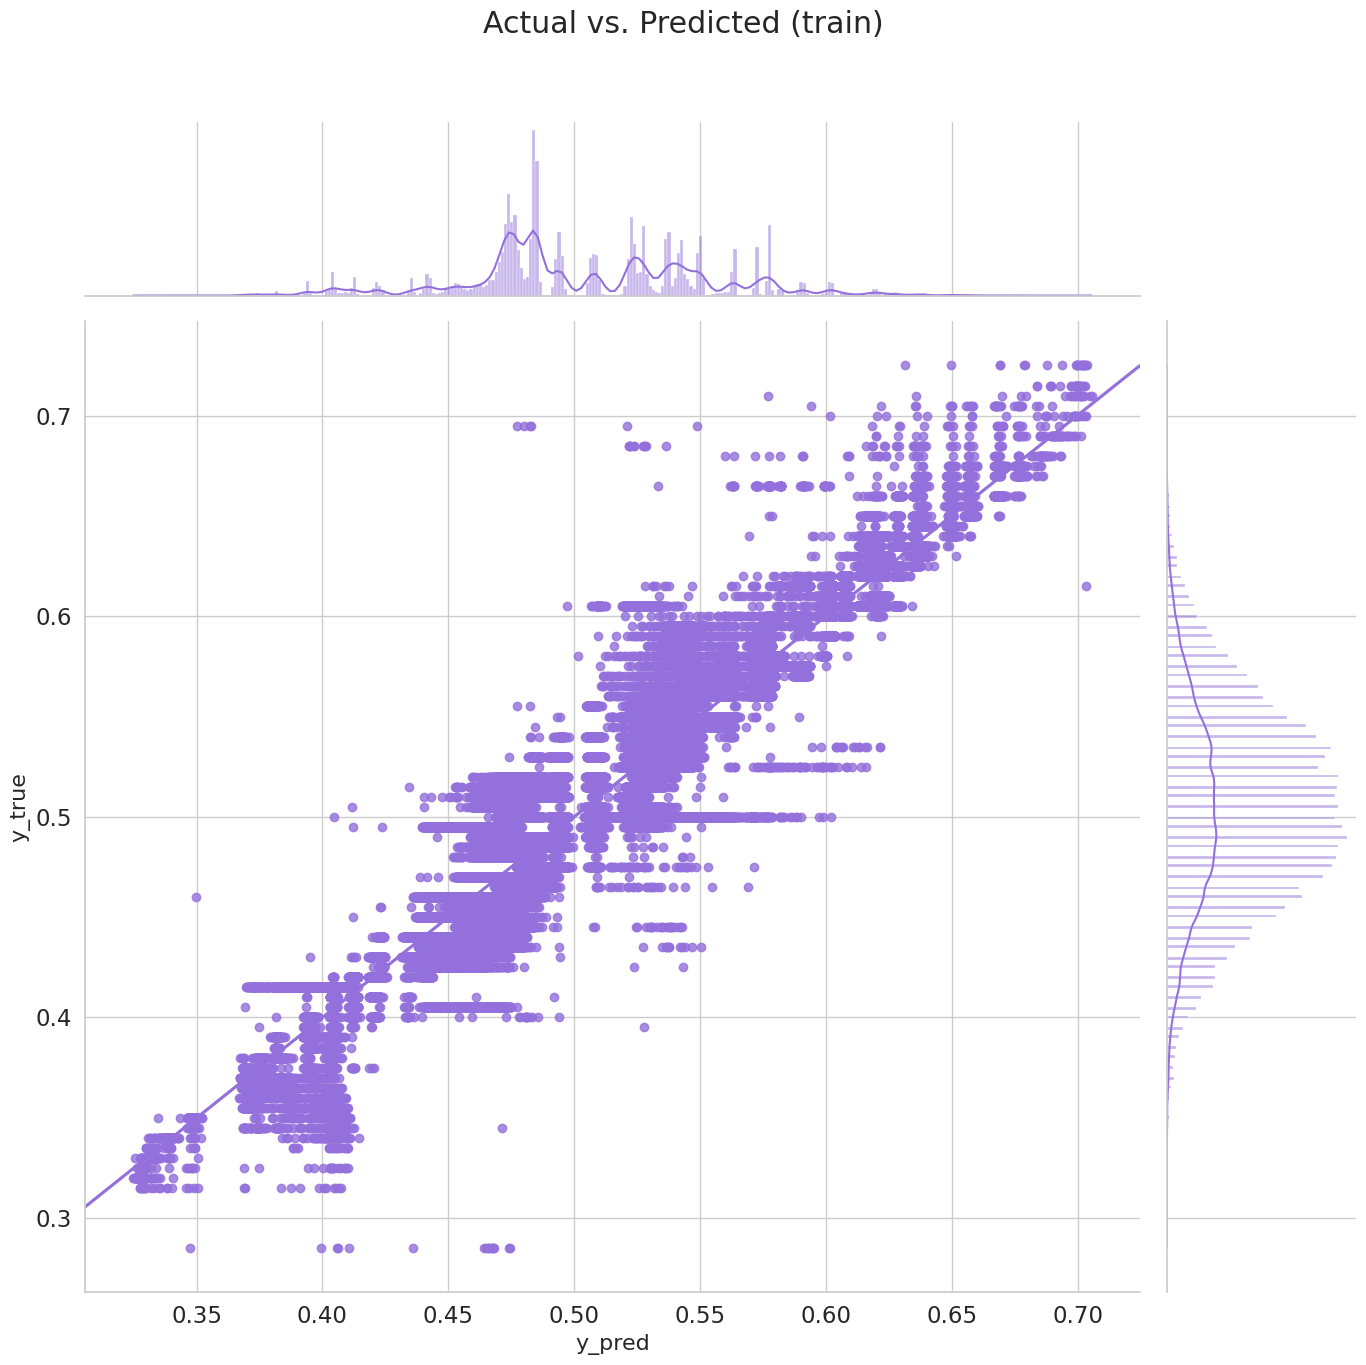

In [12]:
sns.set(style="whitegrid", font_scale=1.5)
g = sns.jointplot(
    x=oof_preds.data[:, 0],
    y=_train[TARGET_NAME],
    kind="reg",
    truncate=False,
    color='#9370DB',
    height=14,
)
g.set_axis_labels('y_pred', 'y_true', fontsize=16)
g.fig.suptitle("Actual vs. Predicted (train)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

# Evaluating The Model on the Validation Set

In [13]:
X_val = _val.drop(columns=[TARGET_NAME])
y_val = _val[TARGET_NAME].values

y_preds = automl.predict(X_val).data[:, 0]

score = r2_score(y_val, y_preds)

print(f'R2 score: {score}')

R2 score: 0.869299939365072


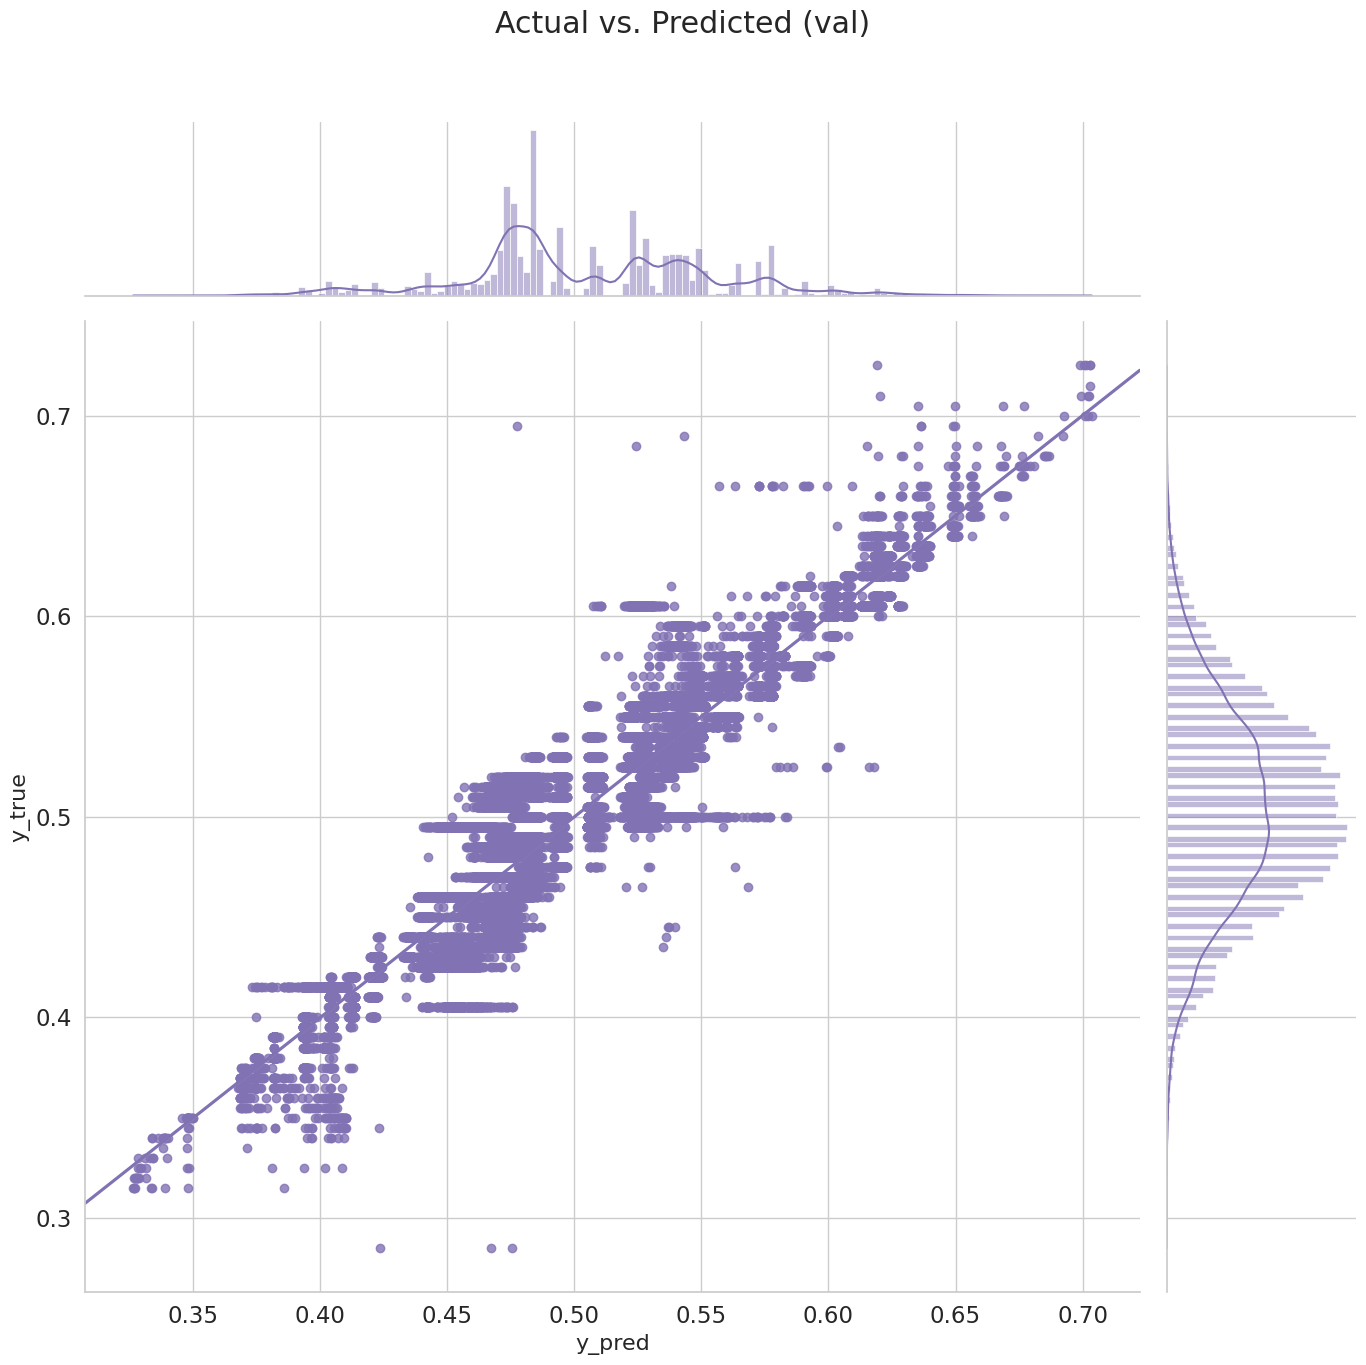

In [14]:
sns.set(style="whitegrid", font_scale=1.5)
g = sns.jointplot(
    x=y_preds,
    y=y_val,
    kind="reg",
    truncate=False,
    color='m',
    height=14,
)
g.set_axis_labels('y_pred', 'y_true', fontsize=16)
g.fig.suptitle("Actual vs. Predicted (val)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

# Making Predictions and Creating a Submission File

In [15]:
test_preds = automl.predict(test)
submission = pd.DataFrame({'id': test.index, 'FloodProbability': test_preds.data[:, 0]})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.578154
1,1117958,0.456718
2,1117959,0.447676
3,1117960,0.466861
4,1117961,0.466689
